# Cuaderno 2: calibración de IPP

En este cuaderno vamos a preparar los datos para IPP, y a correr el algoritmo de calibración. Al final obtendremos una tabla con los parámetros de cada indicador así como las métricas de bondad de ajuste correspondientes. Después, verificaremos que los parámetros obtenidos son consistentes con los que fueron calculados para el reporte (para los cuales se empleó un criterio de precisión más exigente que el de este cuaderno).

## Importamos librerías de Python

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from joblib import Parallel, delayed # esta librería nos ayuda a correr múltiples simulaciones en paralelo

## Importamos el calibrador de IPP

Si IPP está instalado en la PC y los archivos `ppi.py` y `calibrator.py` están enla misma carpeta que tu archivo de trabajo (o que este cuaderno), entonces la importación es más fácil. Como aquí vamos a usar los archivos guardados en el repositorio, la inportación requiere algunos pasos intermedios como descargar los archivos.

In [16]:
import requests

url = 'https://raw.githubusercontent.com/oguerrer/IPP_Colombia/main/tutoriales/calibrator_source.py'
r = requests.get(url)
with open('calibrator.py', 'w') as f:
    f.write(r.text)
from calibrator import *

## Hiperparámetros de la calibración

In [17]:
max_steps = 54 # máximo número de pasos en cada simulación
scalar = 100 # escalar de los indicadores (porcentaje)
min_value = 1e-2 # valor que se le asigna a las brechas que no son positivas

## Cargamos datos de los indicadores

In [38]:
# cargamos base de datos
datos = pd.read_csv('https://raw.githubusercontent.com/oguerrer/IPP_Colombia/main/data/modeling/indicators_sample_final.csv')

# obtenemos columnas con los años
anios_c = np.array([c for c in datos.columns if c.isnumeric()])

# guardamos el número de años
num_years = len(anios_c)

# extraemos las series de tiempo como una matriz (renglón=indicador; columna=tiempo)
series = datos[anios_c].values

# obetnemos vector indicando qué indicadores son instrumentales
R = datos.Instrumental.values

# contamos el número de indicadores instrumentales
n = np.sum(R)

# obetenemos los parámetros de gobernanza
monitoreo = np.ones(n)*datos.Monitoreo.values[0]
estadoDeDerecho = np.ones(n)*datos.EstadoDeDerecho.values[0]

## Cargamos la red de interdependencias

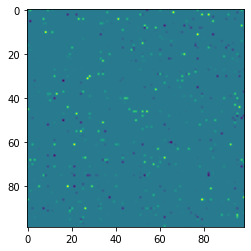

In [19]:
A = np.loadtxt('https://raw.githubusercontent.com/oguerrer/IPP_Colombia/main/data/modeling/network.csv', dtype=float, delimiter=',')

# hacemos un plot de la matriz de adyacencia
plt.imshow(A)
plt.show()

## Construimos vectores con condiciones iniciales y finales para calibrar parámetros $\alpha$

In [20]:
series = datos[anios_c].values
N = len(datos)
Imax = np.ones(N)*scalar
R = datos.Instrumental.values.copy()
I0, IF = get_conditions(series, scalar, min_value, Imax)

condiciones violadas: 0


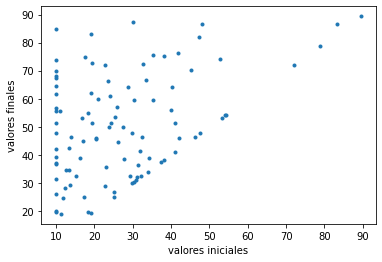

In [21]:
# revisamos que todos los valores iniciales estén por debajo de los finales
print('condiciones violadas:', sum(I0>=IF) )
plt.plot(I0, IF, '.')
plt.xlabel('valores iniciales')
plt.ylabel('valores finales')
plt.show()

## Calculamos tasas de crecimiento exitoso para calibrar parámetros $\beta$

In [22]:
success_emp = get_success_rates(series)

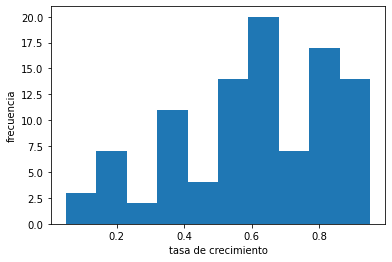

In [23]:
# graficamos un histograma para conocer la distribución de las tasas de crecimiento
plt.hist(success_emp)
plt.xlabel('tasa de crecimiento')
plt.ylabel('frecuencia')
plt.show()

## Cargamos los datos presupuestales y armamos el calendario de desembolsos

In [48]:
dfb = pd.read_csv('https://raw.githubusercontent.com/oguerrer/IPP_Colombia/main/data/modeling/budget_target.csv')

sub_periods = 4
T = len(anios_c)*sub_periods

# armamos el calendario de desembolsos (Bs)
Bs = np.tile(dfb[anios_c].mean(axis=1).values, (len(anios_c),1)).T
usdgs = dfb.values[:,0]
sdg2index = dict(zip(usdgs, range(len(usdgs))))
sdgs = datos.MetaODS.values
B_dict = dict([(i,[sdg2index[sdgs[i]]]) for i in range(N) if R[i]==1])
Bs = get_dirsbursement_schedule(Bs, B_dict, T)

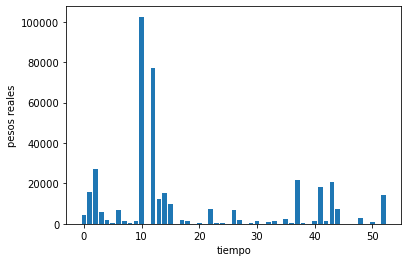

In [49]:
# graficamos el promedio de gasto por meta de los ODS
x = np.arange(Bs.shape[0])
y = Bs.mean(axis=1)
plt.bar(x, y)
plt.xlabel('tiempo')
plt.ylabel('pesos reales')
plt.show()

In [50]:
# imprimimos la tabla de vinculación entre indicadores y las metas de los ODS
B_dict

{0: [0],
 1: [1],
 2: [1],
 3: [2],
 4: [3],
 5: [4],
 6: [4],
 7: [5],
 8: [5],
 9: [5],
 10: [6],
 11: [6],
 12: [7],
 13: [7],
 14: [7],
 15: [7],
 16: [8],
 17: [8],
 18: [8],
 19: [8],
 20: [8],
 21: [8],
 22: [9],
 23: [10],
 24: [10],
 25: [10],
 26: [11],
 27: [11],
 28: [11],
 29: [12],
 30: [12],
 31: [12],
 32: [12],
 33: [12],
 34: [13],
 35: [13],
 36: [14],
 37: [15],
 38: [16],
 39: [17],
 40: [18],
 41: [18],
 42: [18],
 43: [18],
 44: [18],
 45: [18],
 48: [19],
 49: [20],
 50: [21],
 51: [22],
 52: [22],
 53: [22],
 54: [23],
 55: [24],
 56: [24],
 57: [25],
 58: [26],
 59: [27],
 60: [28],
 61: [29],
 63: [30],
 64: [31],
 65: [32],
 66: [33],
 67: [34],
 68: [35],
 69: [36],
 70: [37],
 71: [38],
 72: [39],
 73: [39],
 74: [40],
 75: [41],
 76: [42],
 78: [43],
 80: [44],
 81: [44],
 82: [45],
 83: [46],
 84: [46],
 85: [46],
 86: [47],
 87: [48],
 88: [49],
 89: [50],
 90: [50],
 91: [50],
 92: [51],
 93: [51],
 94: [52],
 95: [52],
 96: [52],
 97: [52]}

## Calibramos IPP y obtenemos los parámetros y métricas de bondad de ajuste

In [51]:
# hiperparámetros extra
parallel_processes = 2 # número de procesos paralelos
tolerance = .8 # tolerancia del error promedio
parametros_calibrados = calibrate(I0=I0, A=A, R=R, qm=monitoreo, rl=estadoDeDerecho,  
    Bs=Bs, B_dict=B_dict, T=T, scalar=scalar, IF=IF, Imax=Imax, success_rates=success_emp, num_years=num_years,
    min_value=min_value, tolerance=tolerance, parallel_processes=parallel_processes)

1 -4148.000000000827 -17930.861959143444
2 -1035.5000000002065 -4291.1488118742955
3 -257.3750000000516 -985.091685998695
4 -62.8437500000129 -234.24117442074274
5 -11.222656249998074 -55.94319413789975
6 -0.6708984374994404 -14.756323727162302
7 -1.5279515665019003 -1.3602691868619354
8 -0.6524524852710247 0.23574820865180746
9 0.011983776269624546 0.11541393114239762
10 0.1254343569740326 0.2565706178780667
11 0.1585412979153631 0.26344746542730835
12 0.29951534831131177 0.39475651985966964
13 0.28002119789660185 0.344205013562893
14 0.23930217712017043 0.20787273459913425
15 0.23366003050002326 0.3018860065933635
16 0.27734556323838333 0.3835683690623596
17 0.3931011528740457 0.30453953312455495
18 0.22306117753447507 0.4069056411944524
19 -0.6502679741138144 -0.011378321382111034
20 0.09336987442657085 0.32307085092226673
21 0.2608034037960836 0.04445616691878451
22 0.23229180199074784 0.3702306764229082
23 0.49908622477118103 0.5311639517710866
24 0.7967724629411717 0.741600754813

In [41]:
# imprimimos resultados
parametros_calibrados

,alpha,beta,T,years,error_alpha,error_beta,scalar,min_value,GoF_alpha,GoF_beta
0,0.648255,0.000415,84.0,21.0,2.625104e-03,0.000465,100.0,0.01,0.992079,0.999240
1,0.481880,0.000297,NaN,NaN,1.375549e-03,0.000138,NaN,NaN,0.994628,0.999810
2,0.687538,0.000357,NaN,NaN,-1.933728e-02,-0.025355,NaN,NaN,0.947727,0.967545
3,0.244865,0.000094,NaN,NaN,4.854567e-03,0.007734,NaN,NaN,0.969339,0.990100
4,0.364650,0.000104,NaN,NaN,2.944870e-03,0.005566,NaN,NaN,0.941768,0.965748
...,...,...,...,...,...,...,...,...,...,...
94,1.058717,0.000729,NaN,NaN,1.706907e-02,0.018975,NaN,NaN,0.970284,0.975712
95,1.930533,0.000569,NaN,NaN,-3.125772e-02,-0.006143,NaN,NaN,0.945520,0.991527
96,0.963528,0.000977,NaN,NaN,-2.486731e-02,-0.047931,NaN,NaN,0.951936,0.942769
97,0.453609,0.000424,NaN,NaN,8.599170e-03,0.019357,NaN,NaN,0.952337,0.961285


In [42]:
# cargamos los parámetros estimados para el reporte y los imprimimos
parametros_reporte = pd.read_csv('https://raw.githubusercontent.com/oguerrer/IPP_Colombia/main/data/modeling/parameters.csv')
parametros_reporte

,alpha,beta,T,years,error_alpha,error_beta,scalar,min_value,GoF_alpha,GoF_beta
0,0.665040,0.000419,84.0,21.0,-1.074973e-02,-0.008542,100.0,0.01,0.967563,0.986055
1,0.492171,0.000306,NaN,NaN,-9.752561e-03,-0.033793,NaN,NaN,0.961911,0.953389
2,0.650542,0.000346,NaN,NaN,1.789178e-02,0.014183,NaN,NaN,0.951634,0.981845
3,0.249414,0.000094,NaN,NaN,1.172551e-03,0.003722,NaN,NaN,0.992594,0.995236
4,0.373473,0.000106,NaN,NaN,9.111018e-04,0.002215,NaN,NaN,0.981984,0.986370
...,...,...,...,...,...,...,...,...,...,...
94,1.066274,0.000766,NaN,NaN,1.228029e-02,0.002407,NaN,NaN,0.978621,0.996918
95,1.599723,0.000576,NaN,NaN,-6.102264e-03,-0.024149,NaN,NaN,0.989364,0.966690
96,0.947468,0.000941,NaN,NaN,-2.145991e-04,0.002203,NaN,NaN,0.999585,0.997369
97,0.452744,0.000434,NaN,NaN,2.633656e-03,-0.000270,NaN,NaN,0.985402,0.999459


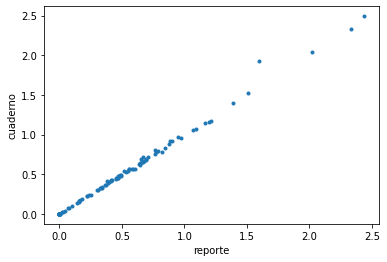

In [44]:
# comparamos los parámetros alfa
x = parametros_reporte['alpha'].values
y = parametros_calibrados['alpha'].values
plt.plot(x, y, '.')
plt.xlabel('reporte')
plt.ylabel('cuaderno')
plt.show()

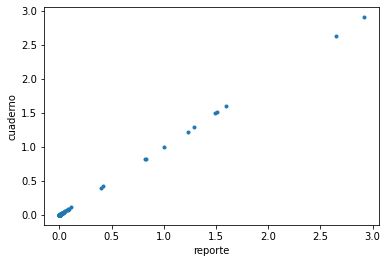

In [45]:
# comparamos los parámetros beta
x = parametros_reporte['beta'].values
y = parametros_calibrados['beta'].values
plt.plot(x, y, '.')
plt.xlabel('reporte')
plt.ylabel('cuaderno')
plt.show()

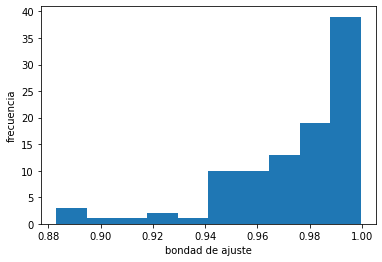

In [46]:
# histograma de la bondad de ajuste de las alfas
plt.hist(parametros_calibrados['GoF_alpha'].values)
plt.xlabel('bondad de ajuste')
plt.ylabel('frecuencia')
plt.show()

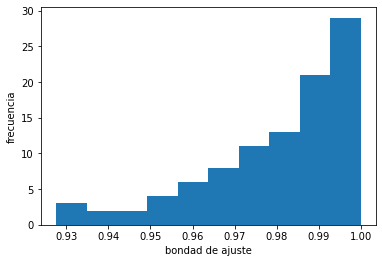

In [47]:
# histograma de la bondad de ajuste de las betas
plt.hist(parametros_calibrados['GoF_beta'].values)
plt.xlabel('bondad de ajuste')
plt.ylabel('frecuencia')
plt.show()